In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

plt.style.use("seaborn-darkgrid")

# 1ra Etapa: Análisis exploratorio de los datos

## Tabla Pedidos

Esta tabla contiene los registros históricos de los pedidos realizados por los clientes en una fecha determinada. Aunque los datos no pertenecen a la cadena de suministro actual, nos sirve como base para armar las restricciones de optimización de la misma.

In [2]:
orders = pd.read_excel("data.xlsx", sheet_name = "OrderList")

orders.columns = ["Pedido", "Fecha", "Puerto de origen", "Transportista", "TPT", "Nivel de servicio", "Envío adelantado [días]", 
                   "Envío tardío [días]", "Cliente", "Producto", "Planta", "Puerto de destino", "Items/pedido", "Peso [kg/item]"]

orders = orders.astype({"Pedido": int})
orders[["Planta", "Puerto de origen", "Puerto de destino"]] = orders[["Planta", "Puerto de origen", "Puerto de destino"]].replace({"[^\d.]": ""}, regex = True).astype(int)

In [3]:
orders.head()

,Pedido,Fecha,Puerto de origen,Transportista,TPT,Nivel de servicio,Envío adelantado [días],Envío tardío [días],Cliente,Producto,Planta,Puerto de destino,Items/pedido,Peso [kg/item]
0,1447296446,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,808,14.30
1,1447158014,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,3188,87.94
2,1447138898,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2331,61.20
3,1447363527,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,847,16.16
4,1447363980,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2163,52.34


*¿La tabla contiene filas duplicadas?*

In [4]:
if orders.duplicated().any():
    print("La tabla tiene filas duplicadas")
    orders.drop_duplicates(inplace = True)
else:
    print("La tabla no tiene filas duplicadas")

La tabla no tiene filas duplicadas


*¿Cuándo se realizaron los pedidos?*

In [5]:
date = orders["Fecha"].unique().astype("datetime64[D]").astype(str)
date[0]

'2013-05-26'

*¿Cuál es el total de pedidos?*

In [6]:
len(orders)

9215

*¿Cuántos pedidos fueron solicitados por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [7]:
g1 = orders.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Pedido": "size"}).rename(columns = {"Pedido": "Recuento de Pedidos"})

total = g1["Recuento de Pedidos"].sum()
g1["%"] = g1["Recuento de Pedidos"].apply(lambda x: x / total * 100)

g1.round(2)

,,,Recuento de Pedidos,%
Planta,Puerto de origen,Puerto de destino,,
3,4,9,8541,92.69
4,5,9,1,0.01
8,4,9,102,1.11
9,4,9,12,0.13
12,4,9,300,3.26
13,4,9,86,0.93
16,9,9,173,1.88


Text(0, 0.5, '% Items')

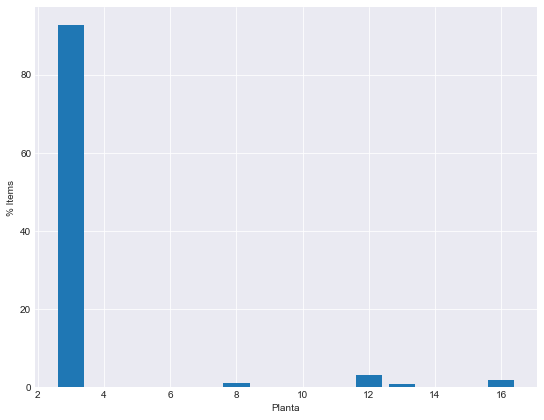

In [8]:
plt.figure(figsize = (9, 7))
plt.bar(g1.index.levels[0], g1["%"])
plt.xlabel("Planta")
plt.ylabel("% Items")

*¿Cuántos items fueron solicitados por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [9]:
g2 = orders.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Items/pedido": ["min", "max", "sum"]})

total = g2[("Items/pedido", "sum")].sum()
g2[("Items", "%")] = g2[("Items/pedido", "sum")].apply(lambda x: x / total * 100)

g2.round(2)

Items/pedido                    \
                                                   min     max       sum   
Planta Puerto de origen Puerto de destino                                  
3      4                9                          235  561847  28611617   
4      5                9                          348     348       348   
8      4                9                          684    5680    277008   
9      4                9                         2301  101069    223830   
12     4                9                          236    1321    112000   
13     4                9                          240    5244     43379   
16     9                9                          280    4464    245133   

                                           Items  
                                               %  
Planta Puerto de origen Puerto de destino         
3      4                9                  96.94  
4      5                9                   0.00  
8      4                9                   0.94  
9      4                9                   0.76  
12     4                9                   0.38  
13     4                9                   0.15  
16     9                9                   0.83

Text(0, 0.5, '% Items')

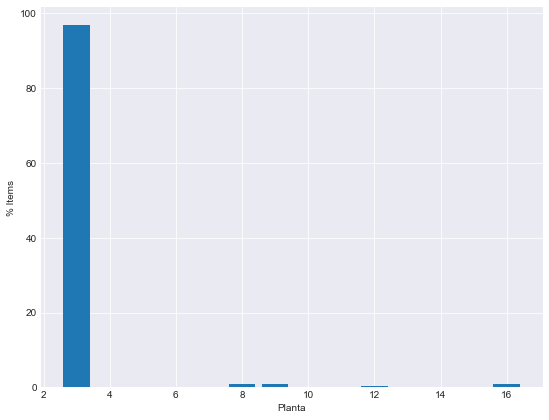

In [10]:
plt.figure(figsize = (9, 7))
plt.bar(g2.index.levels[0], g2[("Items", "%")])
plt.xlabel("Planta")
plt.ylabel("% Items")

*¿Hay alguna correlación entre Recuento de Pedidos e Items/pedido?*

In [11]:

r2, pvalue = pearsonr(g1["Recuento de Pedidos"], g2[("Items/pedido", "sum")])
r2.round(2)

1.0